In [1]:
import pandas as pd
import numpy as np
from experiment_utils import *


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Set the parameters of the experiments and the number of iterations to run each experiment.


In [2]:
# parameters used in experiments
parameters = [
    (b, val, mode) 
    for val in (0.05, 0.1, 0.25, 0.5, 0.75, 1.0) 
    for mode in ('additive', 'multiplicative') 
    for b in (True, False)
]

# parameters used for debugging
parameters = [(True, 1.0, 'additive')]

num_iterations = 1

print(parameters)

[(True, 1.0, 'additive')]


## Run State, County, and SNAP Experiments
#### The results will be saved to a csv in the results folder, which also contains results from previous experiments.

In [3]:
suggest_r = 6

time_period = 'Year'
outcome = 'Below Poverty Level'
covariates = ['Total Population', 'White Alone', 'Black or African American Alone', 
              'Median Household Income', 'Median Housing Value', 'Median Age', 'Total Employment', 
              'Below Poverty Level', 'Housing Units', 'Year']
covariates.remove(outcome)
effect_direction = 'negative'

df_orig = pd.read_csv('raw_data/census_data.csv')
unit='State Name' 

run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run state experiment

df_orig = pd.read_csv('raw_data/census_county_data.csv')
unit='County Name'

run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run county experiment

df_orig = pd.read_csv('raw_data/SNAP_Users_data.csv')
unit = 'CLIENT_ZIP'
time_period = 'YearMonth'
outcome = 'OUTCOME'
covariates = ["Snap_Percentage_Vulnerable", "Male_Population", "Female_Population", "Median_Age", "Total_Population", 
                "Race_White", "Unemployed", "Education_25_Over", "Total_Pop_Below_Poverty", "Year", "Month"]   
effect_direction = 'positive'

run_experiment(df_orig, unit, time_period, outcome, covariates, effect_direction, parameters, num_iterations, suggest_r) # run SNAP experiment


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Results saved to results/results_20240520_002523.csv


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


Results saved to results/results_20240520_002949.csv


The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
Co-variance matrix is underdetermined. Inference will be invalid!
Co-variance matrix is underdetermined. Inference will be invalid!


Results saved to results/results_20240520_003615.csv


## Visualize the results

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


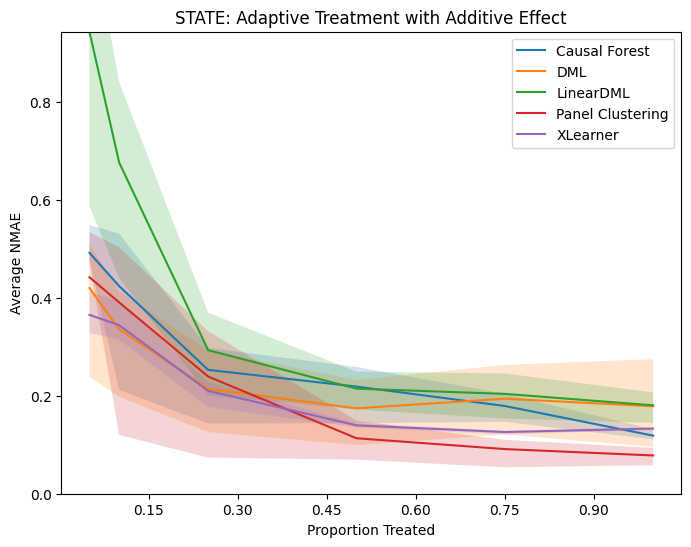

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


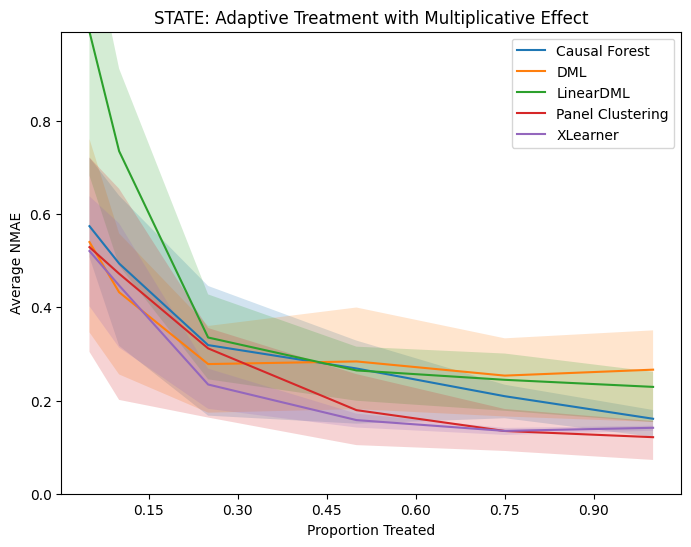

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


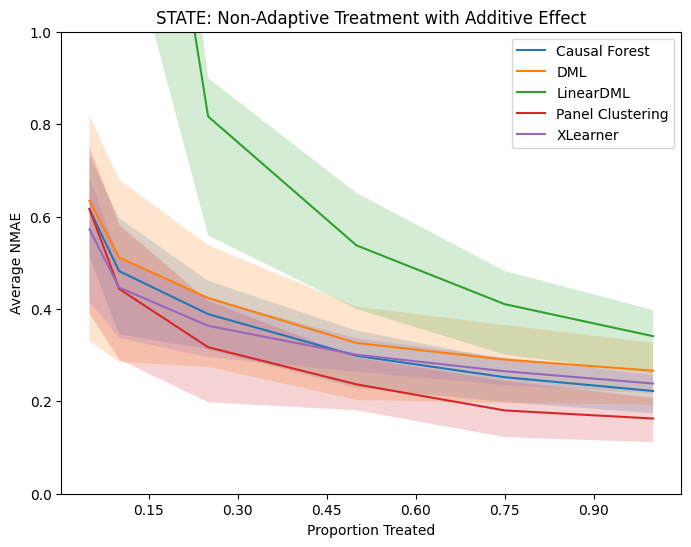

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


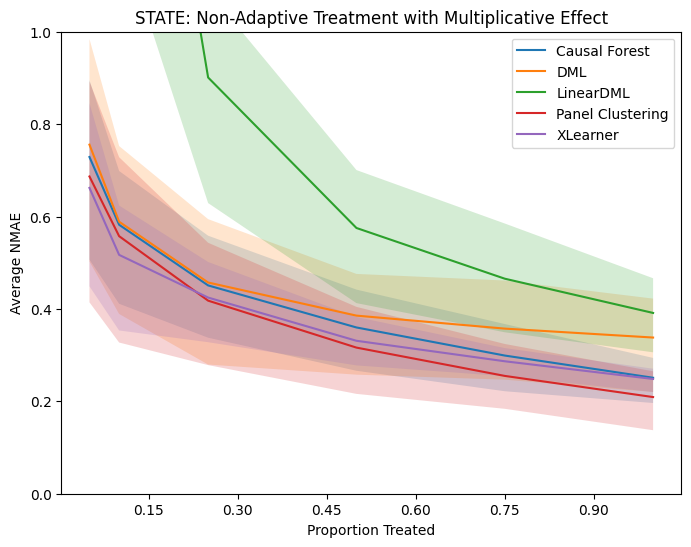

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


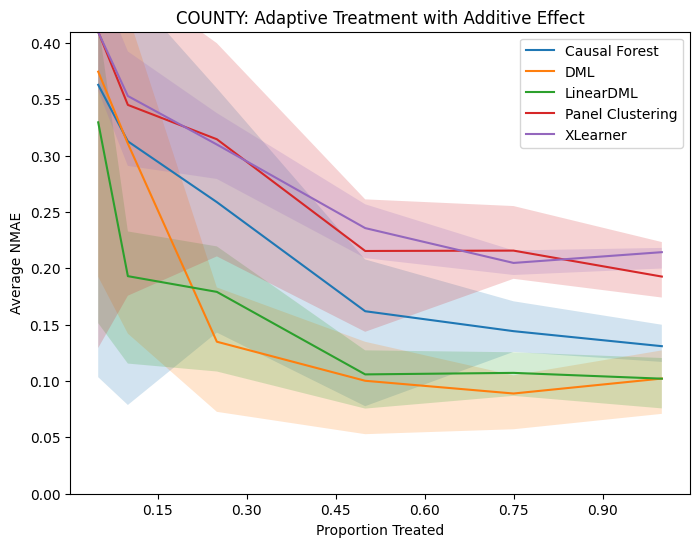

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


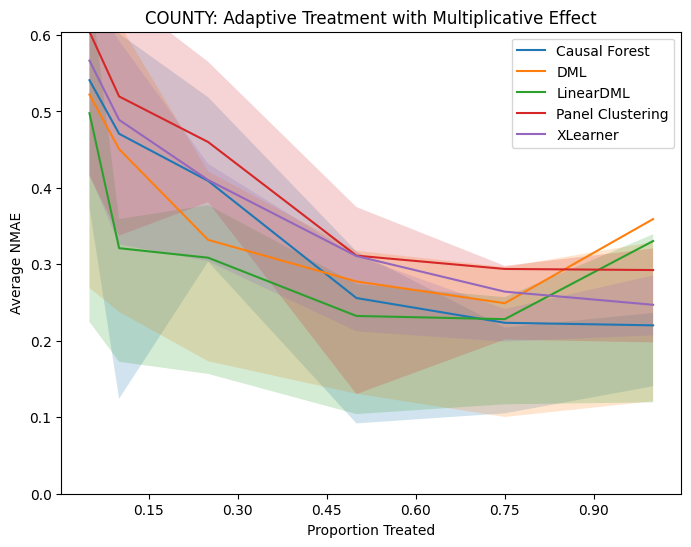

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


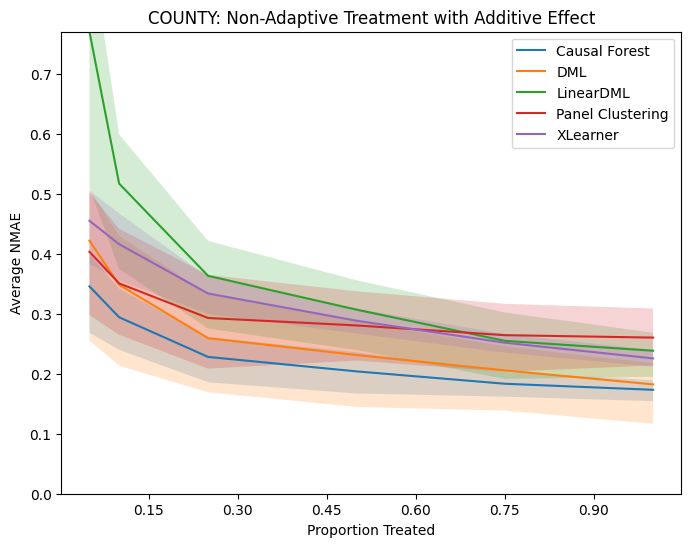

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


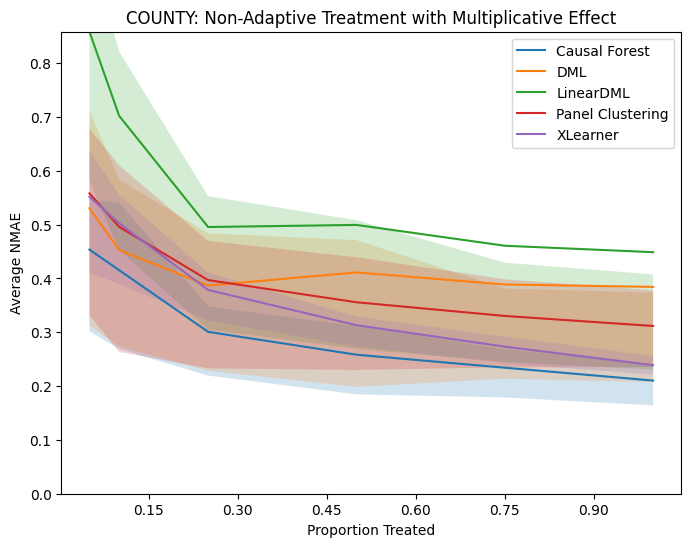

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


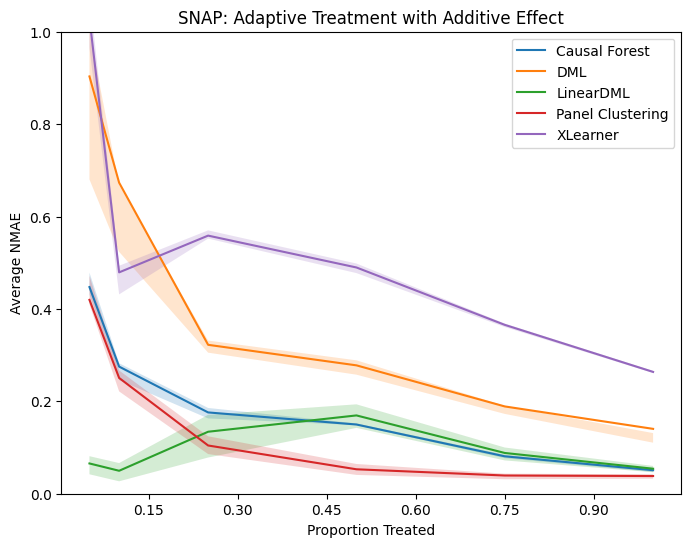

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


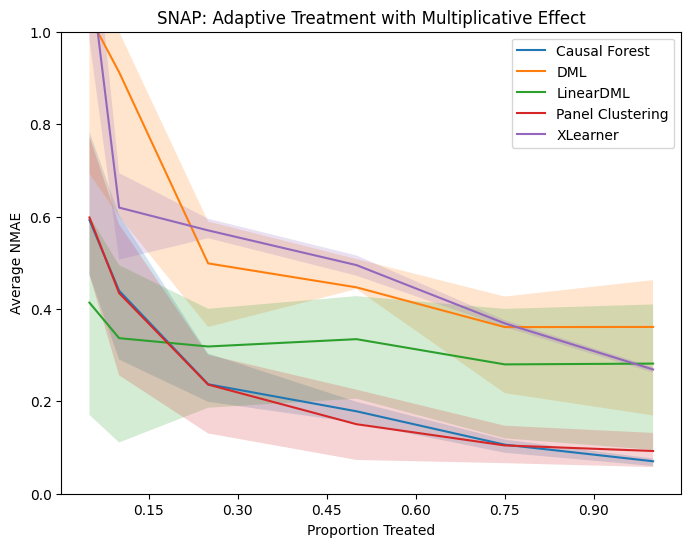

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


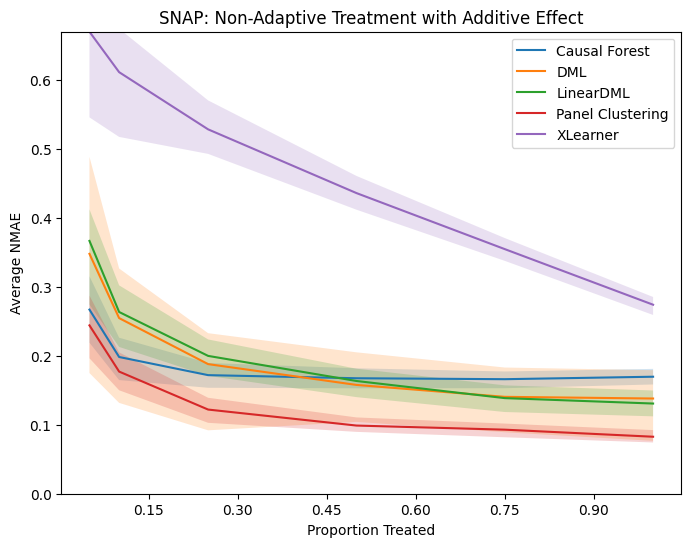

The provided callable <function mean at 0x106e39a20> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.


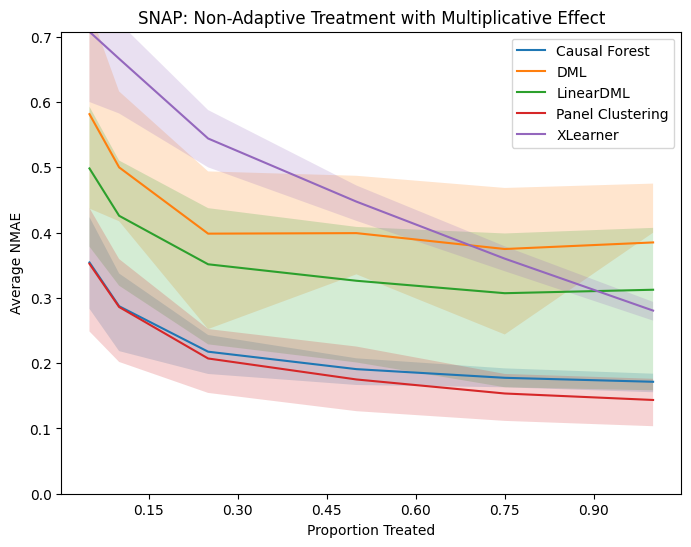

In [4]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import glob

# Load CSV files into a DataFrame
results_path = "results/"
results = pd.concat([pd.read_csv(f) for f in glob.glob(results_path + "*.csv")])

def plot_data(results, unit, adaptive, effect_function, treated_only=False, show_legend=True):
    metric = "NMAE Treated Only" if treated_only else "NMAE"
    filtered_data = results[(results['Unit'] == unit) & 
                            (results['Adaptive Treatment'] == adaptive) & 
                            (results['Treatment Effect Function'] == effect_function)]
    
    if not treated_only: filtered_data = filtered_data[filtered_data['Method'] != "MCNNM"]
    
    best_methods = ["My Estimator", "LinearDML", "Causal Forest (R)", "DML", "XLearner"]
    filtered_data = filtered_data[filtered_data['Method'].isin(best_methods)]
    filtered_data['Method'].replace({"Causal Forest (R)": "Causal Forest", "My Estimator": "Panel Clustering"}, inplace=True)
    
    # Calculate mean NMAE for each Fraction Treated and Method
    means = filtered_data.groupby(['Fraction Treated', 'Method'])[metric].agg(
        mean_nmae=np.mean,
        upper_ci=lambda x: np.quantile(x, 0.75),
        lower_ci=lambda x: np.quantile(x, 0.25),
        num_instances='size'
    ).reset_index()

    # Adjust the unit for the title
    unit_labels = {
        "CLIENT_ZIP": "SNAP",
        "State Name": "STATE",
        "County Name": "COUNTY"
    }
    unit_label = unit_labels.get(unit, unit)
    
    adaptive_text = "Adaptive Treatment" if adaptive else "Non-Adaptive Treatment"
    treated_text = " (Treated Only)" if treated_only else ""
    title_text = f"{unit_label}: {adaptive_text} with {effect_function.title()} Effect"
    filename = f"{title_text}.pdf"

    # Plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    for method, group_data in means.groupby('Method'):
        ax.plot(group_data['Fraction Treated'], group_data['mean_nmae'], label=method)
        ax.fill_between(group_data['Fraction Treated'], group_data['lower_ci'], group_data['upper_ci'], alpha=0.2)
    
    ax.set_title(title_text)
    ax.set_xlabel('Proportion Treated')
    ax.set_ylabel('Average NMAE')
    ax.set_ylim(0, min(1, means['mean_nmae'].max()))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    if show_legend:
        ax.legend()
    plt.show()

    return fig, ax


for unit in results['Unit'].unique():
    for adaptive in results['Adaptive Treatment'].unique():
        for effect_function in results['Treatment Effect Function'].unique():
            fig, ax = plot_data(results, unit, adaptive, effect_function, False)
            plt.close(fig)
        



In [5]:
# Analysis and counting best methods across units
results = results[results['Method'] != "MCNNM"]
unique_units = results['Unit'].unique()
unique_methods = results['Method'].unique()
results['Experiment_ID'] = np.repeat(np.arange(1, len(results) // len(unique_methods) + 1), len(unique_methods))

best_counts = pd.DataFrame(0, index=unique_methods, columns=unique_units)

for unit in unique_units:
    unit_data = results[results['Unit'] == unit]
    for experiment in unit_data['Experiment_ID'].unique():
        experiment_data = unit_data[unit_data['Experiment_ID'] == experiment]
        if not experiment_data.empty:
            best_method = experiment_data.loc[experiment_data['NMAE'].idxmin(), 'Method']
            best_counts.at[best_method, unit] += 1

# Optionally, convert counts to proportions
proportions = best_counts.apply(lambda x: x / x.sum(), axis=0)
print(proportions)

                   State Name  County Name  CLIENT_ZIP
My Estimator         0.390940     0.069432    0.538696
LinearDML            0.025547     0.208661    0.186030
DML                  0.299055     0.342774    0.107380
CausalForestDML      0.064620     0.033071    0.000000
DRLearner            0.000644     0.001279    0.000180
ForestDRLearner      0.007299     0.005299    0.000000
XLearner             0.164234     0.047141    0.000000
Causal Forest (R)    0.047660     0.292344    0.167714
